Paper Referred : [LSTM-SNP: A long short-term memory model inspired from spiking neural P systems](https://drive.google.com/file/d/1V_n4Cn342ShMSTQDLnfiGsBgXEeTGyJE/view?usp=sharing)




Architecture of Neuron :

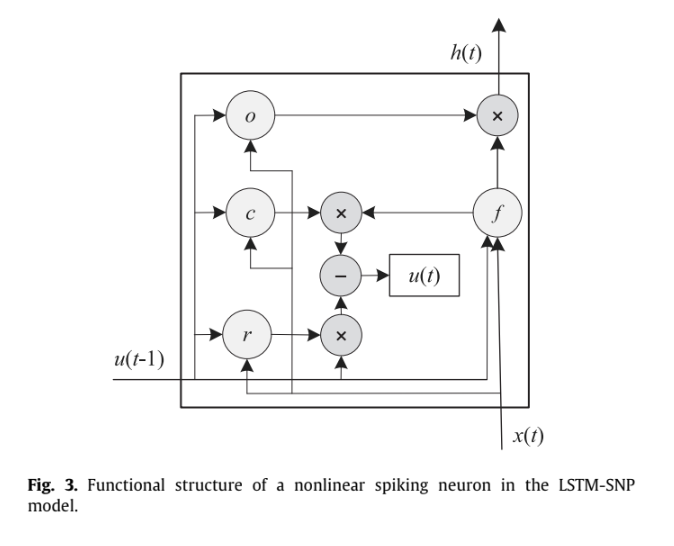


In [1]:
# ============================================================
# ALL IMPORTS (consolidated)
# ============================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

## Reset Gate

$$
r(t) = \rho\left( W_r x(t) + U_r u(t-1) + b_r \right)
$$

## Consumption Gate

$$
c(t) = \rho\left( W_c x(t) + U_c u(t-1) + b_c \right)
$$

## Output Gate

$$
o(t) = \rho\left( W_o x(t) + U_o u(t-1) + b_o \right)
$$

## Generated Spikes

$$
a(t) = f\left( W_a x(t) + U_a u(t-1) + b_a \right)
$$

---

### Parameter Dimensions

$$
W_* \in \mathbb{R}^{d \times h}, \qquad
U_* \in \mathbb{R}^{h \times h}, \qquad
b_* \in \mathbb{R}^{h}
$$

---

### Activations

$$
\rho(\cdot) = \text{hard sigmoid}, \qquad
f(\cdot) = \tanh
$$

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

@tf.keras.utils.register_keras_serializable()
class LSTMSNPCell(layers.Layer):
    """
      This serves as an RNN Cell Instance.
    """
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='hard_sigmoid',
                 **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.state_size = units      # REQUIRED
        self.output_size = units     # REQUIRED

        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(
            shape=(input_dim, self.units * 4),
            initializer='glorot_uniform',
            name='kernel'
        )

        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 4),
            initializer='orthogonal',
            name='recurrent_kernel'
        )

        self.bias = self.add_weight(
            shape=(self.units * 4,),
            initializer='zeros',
            name='bias'
        )

    def call(self, inputs, states):
        u_tm1 = states[0]

        z = tf.matmul(inputs, self.kernel) + \
            tf.matmul(u_tm1, self.recurrent_kernel) + self.bias

        z0 = z[:, :self.units]
        z1 = z[:, self.units:2*self.units]
        z2 = z[:, 2*self.units:3*self.units]
        z3 = z[:, 3*self.units:]

        r = self.recurrent_activation(z0) #reset :how much previous state reset
        c = self.recurrent_activation(z1) #how much of previous state (u) is consumed.Wrt to current i/p, refer to the T/g(t)->f(t) philosophy
        o = self.recurrent_activation(z2) # generation : how much spike generated.
        a = self.recurrent_activation(z3)

        u = r * u_tm1 - c * a #internal state of LSTM-SNP
        h = o * a #output of SNP

        return h, [u]

Wrapping in RNN (As directeed in paper)

In [4]:
def build_model(input_dim, units, batch_size):
    cell = LSTMSNPCell(units)
    rnn = layers.RNN(cell, return_sequences=False, stateful=True)

    inputs = tf.keras.Input(
        batch_shape=(batch_size, 1, input_dim)
    )
    x = rnn(inputs)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )

    return model

In [5]:
model = build_model(input_dim=1, units=8, batch_size=1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (1, 1, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (1, 8)                 │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1)                 │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

**TESTING ON DOW_JONES DATASET (from GITHUB REPO attached to paper)**

# LSTM-SNP Experiment Pipeline — Dow Jones Dataset

## 1. Load Time Series Data
- Read monthly Dow Jones closing prices
- Parse date column
- Extract raw numeric values


## 2. First-Order Differencing
- Remove trend component
- Compute:

  diff(t) = raw(t) − raw(t−1)

- Purpose: make series more stationary


## 3. Convert to Supervised Learning Format
- Use lag = 1
- Create input-output pairs:

  X(t) = diff(t−1)  
  y(t) = diff(t)

- Fill initial NaN with 0


## 4. Train-Test Split
- Last 60 samples → Test set
- Remaining samples → Training set



## 5. Feature Scaling
- Apply MinMaxScaler
- Scale to range [-1, 1]
- Fit scaler on training set only
- Transform both train and test


## 6. Reshape for RNN Input
- Reshape X_train to:

  (samples, timesteps=1, features=1)

- Required input shape for RNN


## 7. Model Construction
- Custom LSTM-SNP cell (8 units)
- Wrapped inside RNN layer
- Dense(1) output layer
- Loss: Mean Squared Error
- Optimizer: Adam



## 8. Model Training
- Epochs: 200
- Batch size: 1
- shuffle=False (preserve sequence order)
- Backpropagation Through Time



## 9. Rolling Prediction (One-Step Ahead)
For each test sample:
- Predict next differenced value
- Inverse scale
- Inverse differencing:

  predicted_raw(t) = predicted_diff(t) + raw(t−1)



## 10. Evaluation Metrics
- RMSE
- MSE
- NMSE:

  NMSE = MSE / ||prediction − mean(actual)||²


## 11. Visualization
- Plot actual vs predicted
- Observe tracking behavior

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

def parser(x):
    return pd.to_datetime(x, format='%Y-%m')

series = pd.read_csv(
    'content/monthly-closings-of-the-dowjones.csv',
    header=0,
    parse_dates=[0],
    index_col=0
)

raw_values = series.values.flatten()
print(f"Data shape: {raw_values.shape}")
print(f"First 5 values: {raw_values[:5]}")


Data shape: (291,)
First 5 values: [3645.  3626.  3634.  3620.5 3607. ]


In [7]:
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

diff_values = difference(raw_values, 1)

In [8]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df.values

supervised = timeseries_to_supervised(diff_values, 1)

In [9]:
train, test = supervised[:-60], supervised[-60:]

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [11]:
X_train, y_train = train_scaled[:, 0:-1], train_scaled[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test, y_test = test_scaled[:, 0:-1], test_scaled[:, -1]

In [12]:
# ============================================================
# 30-Run Experiment Protocol (matching reference test.py)
# ============================================================

all_rmse = []
all_mse = []
all_nmse = []
all_predictions = []

for run in range(30):
    print(f'\n===== RUN {run+1}/30 =====')

    # Fix #4: Per-run seed control
    np.random.seed(run)
    tf.random.set_seed(run)

    # Build stateful model (Fix #2)
    tf.keras.backend.clear_session()
    model = build_model(input_dim=1, units=8, batch_size=1)

    # Fix #3: Unit forget bias — set consume gate (c) bias to 1.0
    # Access the RNN layer's cell weights
    rnn_layer = model.layers[1]  # RNN layer
    cell = rnn_layer.cell
    weights = cell.get_weights()  # [kernel, recurrent_kernel, bias]
    bias = weights[2].copy()
    bias[8:16] = 1.0  # units=8, so bias[units:2*units] = bias[8:16]
    weights[2] = bias
    cell.set_weights(weights)

    # Fix #2: Stateful training with manual epoch loop + reset_states
    for epoch in range(100):
        model.fit(
            X_train,
            y_train,
            epochs=1,
            batch_size=1,
            verbose=0,
            shuffle=False
        )
        rnn_layer.reset_states()

    print(f'Training complete for run {run+1}')

    # Fix #6: Warm-up prediction pass on training data
    # This conditions the hidden states before test predictions
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    model.predict(train_reshaped, batch_size=1, verbose=0)

    # Test predictions (single-step)
    predictions = []
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        X_input = X.reshape(1, 1, len(X))
        yhat = model.predict(X_input, batch_size=1, verbose=0)[0, 0]

        # Invert scaling
        new_row = [x for x in X] + [yhat]
        array = np.array(new_row).reshape(1, len(new_row))
        inverted = scaler.inverse_transform(array)[0, -1]

        # Invert differencing
        inverted = inverted + raw_values[len(train) + i]

        predictions.append(inverted)

        expected = raw_values[len(train) + i + 1]
        print(f'Month={i+1}, Predicted={inverted:.4f}, Expected={expected:.4f}')

    # Compute metrics
    actual = raw_values[-60:]
    rmse = sqrt(mean_squared_error(actual, predictions))
    mse = mean_squared_error(actual, predictions)
    meanV = np.mean(actual)
    dominator = np.linalg.norm(np.array(predictions) - meanV, 2)
    nmse = mse / np.power(dominator, 2)

    all_rmse.append(rmse)
    all_mse.append(mse)
    all_nmse.append(nmse)
    all_predictions.append(predictions)

    print(f'Run {run+1} — RMSE: {rmse:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.10f}')


===== RUN 1/30 =====
Training complete for run 1
Month=1, Predicted=3798.8010, Expected=3796.0000
Month=2, Predicted=3795.8966, Expected=3793.0000
Month=3, Predicted=3792.8769, Expected=3766.0000
Month=4, Predicted=3765.2583, Expected=3747.0000
Month=5, Predicted=3746.4587, Expected=3754.0000
Month=6, Predicted=3754.1107, Expected=3756.0000
Month=7, Predicted=3755.9790, Expected=3767.0000
Month=8, Predicted=3767.2119, Expected=3751.0000
Month=9, Predicted=3750.5258, Expected=3769.0000
Month=10, Predicted=3769.3938, Expected=3760.0000
Month=11, Predicted=3759.7054, Expected=3785.0000
Month=12, Predicted=3785.5712, Expected=3776.0000
Month=13, Predicted=3775.7079, Expected=3755.0000
Month=14, Predicted=3754.4061, Expected=3755.0000
Month=15, Predicted=3754.9390, Expected=3751.0000
Month=16, Predicted=3750.8312, Expected=3776.0000
Month=17, Predicted=3776.5643, Expected=3847.0000
Month=18, Predicted=3848.7292, Expected=3830.0000
Month=19, Predicted=3829.5048, Expected=3881.0000
Month=20,

In [13]:
# ============================================================
# Summary Statistics (matching reference calculate.py)
# ============================================================

print('\n===== FINAL RESULTS (30 runs) =====')
print(f'RMSE: {np.mean(all_rmse):.10f} ± {np.var(all_rmse):.15f}')
print(f'MSE:  {np.mean(all_mse):.10f} ± {np.var(all_mse):.15f}')
print(f'NMSE: {np.mean(all_nmse):.10f} ± {np.var(all_nmse):.15f}')

# Best run (minimum RMSE)
best_idx = all_rmse.index(min(all_rmse))
print(f'\nBest run: {best_idx+1}')
print(f'  RMSE: {all_rmse[best_idx]:.15f}')
print(f'  MSE:  {all_mse[best_idx]:.15f}')
print(f'  NMSE: {all_nmse[best_idx]:.15f}')

print(f'\nAll RMSE values: {all_rmse}')


===== FINAL RESULTS (30 runs) =====
RMSE: 24.4196147247 ± 0.000145681726041
MSE:  596.3177289840 ± 0.347420943269070
NMSE: 0.0027238972 ± 0.000000000033093

Best run: 30
  RMSE: 24.390693059890278
  MSE:  594.905907941779788
  NMSE: 0.002708029854072

All RMSE values: [24.421708768593497, 24.43139853210146, 24.4385101615656, 24.425315553156196, 24.4369683936223, 24.43419458244958, 24.415052499949866, 24.420612919597254, 24.420998272802727, 24.422209456175576, 24.419355645665235, 24.413712831928606, 24.426910831592437, 24.408315050170895, 24.42184726861392, 24.419714643137347, 24.42042674177704, 24.40455294210039, 24.417725017441217, 24.424721325881947, 24.43277544655598, 24.444738569666555, 24.391469667432194, 24.412759569958016, 24.403145363630646, 24.41187819431648, 24.41852836857518, 24.41793828727647, 24.420263775083086, 24.39069305989028]


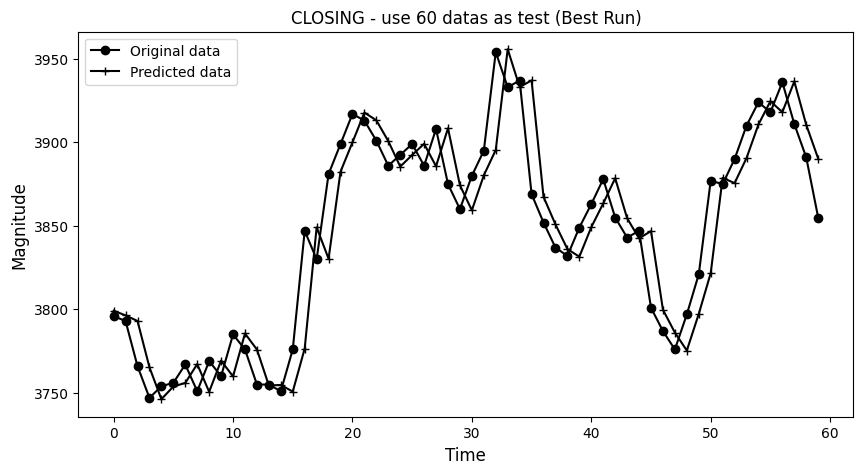

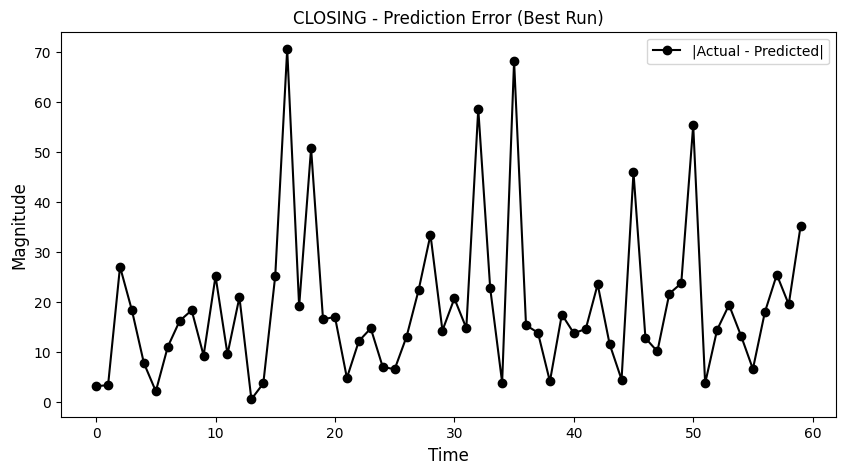

In [14]:
# Plot best run predictions vs actual
actual = raw_values[-60:]
best_predictions = all_predictions[best_idx]

plt.figure(figsize=(10, 5))
plt.plot(actual, 'k-o', label='Original data')
plt.plot(best_predictions, 'k+-', label='Predicted data')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.title('CLOSING - use 60 datas as test (Best Run)')
plt.show()

# Error plot
error = abs(np.array(actual) - np.array(best_predictions))
plt.figure(figsize=(10, 5))
plt.plot(error, 'k-o', label='|Actual - Predicted|')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.title('CLOSING - Prediction Error (Best Run)')
plt.show()

In [15]:
# Final metrics summary from best run
print('=== Best Run Metrics ===')
print(f'RMSE: {all_rmse[best_idx]}')
print(f'MSE:  {all_mse[best_idx]}')
print(f'NMSE: {all_nmse[best_idx]}')

=== Best Run Metrics ===
RMSE: 24.39069305989028
MSE:  594.9059079417798
NMSE: 0.0027080298540719024


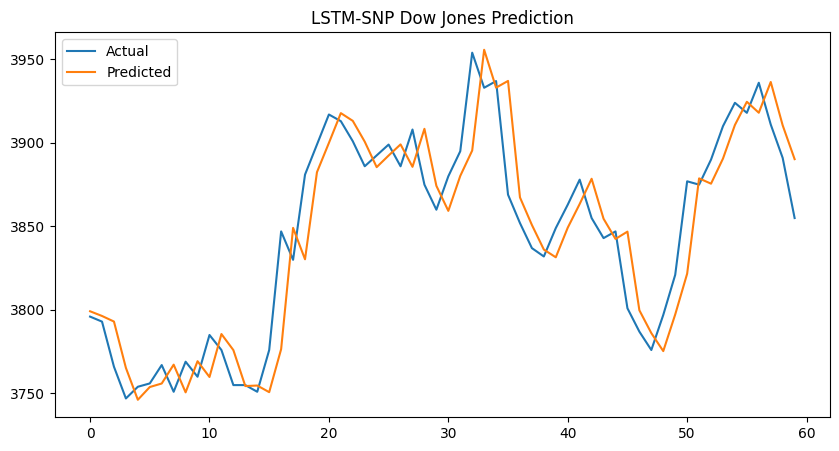

In [16]:
plt.figure(figsize=(10,5))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title("LSTM-SNP Dow Jones Prediction")
plt.show()

Report

# **Bi-LSTM SNP**

In [17]:
def build_bilstm_snp_model(input_dim, units, batch_size):
    """
    Stateful BiLSTM-SNP model.
    Both forward and backward cells are independent LSTMSNPCell clones.
    Bidirectional merge_mode='concat' → output dim = 2*units.
    """
    cell_fw = LSTMSNPCell(units)
    cell_bw = LSTMSNPCell(units)

    rnn_fw = layers.RNN(cell_fw, return_sequences=False, stateful=True)
    rnn_bw = layers.RNN(cell_bw, return_sequences=False, stateful=True, go_backwards=True)

    bi_rnn = layers.Bidirectional(rnn_fw, backward_layer=rnn_bw)

    inputs = tf.keras.Input(batch_shape=(batch_size, 1, input_dim))
    x = bi_rnn(inputs)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [18]:
bi_model_check = build_bilstm_snp_model(input_dim=1, units=8, batch_size=1)
bi_model_check.summary()
print(f"\nTotal params: {bi_model_check.count_params()}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (1, 1, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (1, 16)                │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657 (2.57 KB)

 Trainable params: 657 (2.57 KB)

 Non-trainable params: 0 (0.00 B)


Total params: 657


In [19]:
# ============================================================
# BiLSTM-SNP: 30-Run Experiment Protocol
# (Protocol-aligned with baseline LSTM-SNP)
# ============================================================

bi_all_rmse = []
bi_all_mse = []
bi_all_nmse = []
bi_all_predictions = []

for run in range(30):
    print(f'\n===== BiLSTM-SNP RUN {run+1}/30 =====')

    # Per-run seed control
    np.random.seed(run)
    tf.random.set_seed(run)
    tf.keras.backend.clear_session()

    # Build stateful BiLSTM model
    model = build_bilstm_snp_model(input_dim=1, units=8, batch_size=1)

    # Unit forget bias for BOTH forward and backward cells
    bi_layer = model.layers[1]  # Bidirectional layer
    for rnn_sub in [bi_layer.forward_layer, bi_layer.backward_layer]:
        cell = rnn_sub.cell
        weights = cell.get_weights()  # [kernel, recurrent_kernel, bias]
        bias = weights[2].copy()
        bias[8:16] = 1.0  # units=8, bias[units:2*units] = consume gate
        weights[2] = bias
        cell.set_weights(weights)

    # Stateful training: manual epoch loop + reset_states
    for epoch in range(100):
        model.fit(
            X_train,
            y_train,
            epochs=1,
            batch_size=1,
            verbose=0,
            shuffle=False
        )
        bi_layer.forward_layer.reset_states()
        bi_layer.backward_layer.reset_states()

    print(f'Training complete for run {run+1}')

    # Warm-up prediction pass on training data
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    model.predict(train_reshaped, batch_size=1, verbose=0)

    # Test predictions (single-step)
    predictions = []
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        X_input = X.reshape(1, 1, len(X))
        yhat = model.predict(X_input, batch_size=1, verbose=0)[0, 0]

        # Invert scaling
        new_row = [x for x in X] + [yhat]
        array = np.array(new_row).reshape(1, len(new_row))
        inverted = scaler.inverse_transform(array)[0, -1]

        # Invert differencing
        inverted = inverted + raw_values[len(train) + i]

        predictions.append(inverted)

        expected = raw_values[len(train) + i + 1]
        print(f'Month={i+1}, Predicted={inverted:.4f}, Expected={expected:.4f}')

    # Compute metrics (matching calculate.py)
    actual = raw_values[-60:]
    rmse = sqrt(mean_squared_error(actual, predictions))
    mse = mean_squared_error(actual, predictions)
    meanV = np.mean(actual)
    dominator = np.linalg.norm(np.array(predictions) - meanV, 2)
    nmse = mse / np.power(dominator, 2)

    bi_all_rmse.append(rmse)
    bi_all_mse.append(mse)
    bi_all_nmse.append(nmse)
    bi_all_predictions.append(predictions)

    print(f'Run {run+1} — RMSE: {rmse:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.10f}')


===== BiLSTM-SNP RUN 1/30 =====
Training complete for run 1
Month=1, Predicted=3798.9428, Expected=3796.0000
Month=2, Predicted=3796.1341, Expected=3793.0000
Month=3, Predicted=3793.0665, Expected=3766.0000
Month=4, Predicted=3765.4150, Expected=3747.0000
Month=5, Predicted=3746.5445, Expected=3754.0000
Month=6, Predicted=3754.1551, Expected=3756.0000
Month=7, Predicted=3756.0742, Expected=3767.0000
Month=8, Predicted=3767.3201, Expected=3751.0000
Month=9, Predicted=3750.6774, Expected=3769.0000
Month=10, Predicted=3769.4745, Expected=3760.0000
Month=11, Predicted=3759.8562, Expected=3785.0000
Month=12, Predicted=3785.6558, Expected=3776.0000
Month=13, Predicted=3775.8827, Expected=3755.0000
Month=14, Predicted=3754.5514, Expected=3755.0000
Month=15, Predicted=3755.0223, Expected=3751.0000
Month=16, Predicted=3750.9314, Expected=3776.0000
Month=17, Predicted=3776.6301, Expected=3847.0000
Month=18, Predicted=3848.7239, Expected=3830.0000
Month=19, Predicted=3829.7944, Expected=3881.000

KeyboardInterrupt: 

In [ ]:
# ============================================================
# BiLSTM-SNP Summary Statistics
# ============================================================

print('\n===== BiLSTM-SNP FINAL RESULTS (30 runs) =====')
print(f'RMSE: {np.mean(bi_all_rmse):.10f} ± {np.var(bi_all_rmse):.15f}')
print(f'MSE:  {np.mean(bi_all_mse):.10f} ± {np.var(bi_all_mse):.15f}')
print(f'NMSE: {np.mean(bi_all_nmse):.10f} ± {np.var(bi_all_nmse):.15f}')

best_bi_idx = bi_all_rmse.index(min(bi_all_rmse))
print(f'\nBest run: {best_bi_idx+1}')
print(f'  RMSE: {bi_all_rmse[best_bi_idx]:.15f}')
print(f'  MSE:  {bi_all_mse[best_bi_idx]:.15f}')
print(f'  NMSE: {bi_all_nmse[best_bi_idx]:.15f}')

# Plot best run
actual = raw_values[-60:]
best_bi_preds = bi_all_predictions[best_bi_idx]

plt.figure(figsize=(10, 5))
plt.plot(actual, 'k-o', label='Original data')
plt.plot(best_bi_preds, 'k+-', label='Predicted data')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.title('BiLSTM-SNP — CLOSING (Best Run)')
plt.show()

# **Incorporating attention mechanism**

# Attention Mechanism in LSTM-SNP

## 1. Sequence Representation

Standard LSTM-SNP compresses a sequence as:

$$
x_1, x_2, \dots, x_T \longrightarrow h_T
$$

This creates an information bottleneck.

Instead, with attention we retain all hidden states:

$$
H = \{h_1, h_2, \dots, h_T\}
$$

where:

$$
h_t \in \mathbb{R}^{d}
$$



## 2. Alignment Score Function (Additive Attention)

Each hidden state receives a score:

$$
e_t = v^\top \tanh(W h_t + b)
$$

where:

$$
W \in \mathbb{R}^{d \times d},
\quad
v \in \mathbb{R}^{d},
\quad
b \in \mathbb{R}^{d}
$$



## 3. Softmax Normalization

Attention weights are computed as:

$$
\alpha_t =
\frac{\exp(e_t)}
{\sum_{k=1}^{T} \exp(e_k)}
$$

with:

$$
\sum_{t=1}^{T} \alpha_t = 1
$$


## 4. Context Vector

The context vector is a weighted sum of hidden states:

$$
c = \sum_{t=1}^{T} \alpha_t h_t
$$

where:

$$
c \in \mathbb{R}^{d}
$$



## 5. Final Prediction

The final output is computed as:

$$
\hat{y} = W_o c + b_o
$$

where:

$$
W_o \in \mathbb{R}^{1 \times d},
\quad
b_o \in \mathbb{R}
$$


## 6. Full Compact Form

$$
e_t = v^\top \tanh(W h_t + b)
$$

$$
\alpha_t =
\frac{\exp(e_t)}
{\sum_{k=1}^{T} \exp(e_k)}
$$

$$
c = \sum_{t=1}^{T} \alpha_t h_t
$$

$$
\hat{y} = W_o c + b_o
$$

In [ ]:
class SimpleAttention(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, hidden_states):
        # hidden_states: (batch, T, units)

        score = self.V(tf.nn.tanh(self.W(hidden_states)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * hidden_states
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [ ]:
def build_lstm_snp_attention(input_dim, units, batch_size):
    """
    Stateful LSTM-SNP + Attention model.
    return_sequences=True to provide all hidden states to attention.
    """
    cell = LSTMSNPCell(units)
    rnn_layer = layers.RNN(cell, return_sequences=True, stateful=True)

    inputs = tf.keras.Input(batch_shape=(batch_size, None, input_dim))
    sequence_output = rnn_layer(inputs)

    attention_layer = SimpleAttention(units)
    context = attention_layer(sequence_output)

    outputs = layers.Dense(1)(context)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# ============================================================
# LSTM-SNP + Attention (lag=1) — DEGENERATE ATTENTION CONTROL
# With T=1 timestep: softmax([e_1]) = [1.0], α_1 = 1 always.
# Context vector = h_1. Attention has zero selective effect.
# This serves as a control experiment.
# ============================================================
att_model_check = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)
att_model_check.summary()

In [ ]:
# ============================================================
# LSTM-SNP + Attention (lag=1): 30-Run Protocol
# DEGENERATE ATTENTION CONTROL (T=1, α₁=1 always)
# ============================================================

att1_all_rmse = []
att1_all_mse = []
att1_all_nmse = []
att1_all_predictions = []

for run in range(30):
    print(f'\n===== Attention(lag=1) RUN {run+1}/30 =====')

    # Per-run seed control
    np.random.seed(run)
    tf.random.set_seed(run)
    tf.keras.backend.clear_session()

    # Build stateful attention model
    model = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)

    # Unit forget bias initialization
    rnn_layer = model.layers[1]  # RNN layer
    cell = rnn_layer.cell
    weights = cell.get_weights()
    bias = weights[2].copy()
    bias[8:16] = 1.0
    weights[2] = bias
    cell.set_weights(weights)

    # Stateful training: manual epoch loop + reset_states
    for epoch in range(100):
        model.fit(
            X_train,
            y_train,
            epochs=1,
            batch_size=1,
            verbose=0,
            shuffle=False
        )
        rnn_layer.reset_states()

    print(f'Training complete for run {run+1}')

    # Warm-up prediction pass
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    model.predict(train_reshaped, batch_size=1, verbose=0)

    # Test predictions (single-step)
    predictions = []
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        X_input = X.reshape(1, 1, len(X))
        yhat = model.predict(X_input, batch_size=1, verbose=0)[0, 0]

        # Invert scaling
        new_row = [x for x in X] + [yhat]
        array = np.array(new_row).reshape(1, len(new_row))
        inverted = scaler.inverse_transform(array)[0, -1]

        # Invert differencing
        inverted = inverted + raw_values[len(train) + i]

        predictions.append(inverted)

        expected = raw_values[len(train) + i + 1]
        print(f'Month={i+1}, Predicted={inverted:.4f}, Expected={expected:.4f}')

    # Compute metrics
    actual = raw_values[-60:]
    rmse = sqrt(mean_squared_error(actual, predictions))
    mse = mean_squared_error(actual, predictions)
    meanV = np.mean(actual)
    dominator = np.linalg.norm(np.array(predictions) - meanV, 2)
    nmse = mse / np.power(dominator, 2)

    att1_all_rmse.append(rmse)
    att1_all_mse.append(mse)
    att1_all_nmse.append(nmse)
    att1_all_predictions.append(predictions)

    print(f'Run {run+1} — RMSE: {rmse:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.10f}')

In [ ]:
# ============================================================
# Attention (lag=1) Summary — Degenerate Attention Control
# ============================================================

print('\n===== LSTM-SNP + Attention (lag=1) — DEGENERATE ATTENTION CONTROL =====')
print('Note: T=1, softmax([e_1]) = [1.0], α_1 = 1 always. Attention has NO selective effect.')
print(f'\nRMSE: {np.mean(att1_all_rmse):.10f} ± {np.var(att1_all_rmse):.15f}')
print(f'MSE:  {np.mean(att1_all_mse):.10f} ± {np.var(att1_all_mse):.15f}')
print(f'NMSE: {np.mean(att1_all_nmse):.10f} ± {np.var(att1_all_nmse):.15f}')

best_att1_idx = att1_all_rmse.index(min(att1_all_rmse))
print(f'\nBest run: {best_att1_idx+1}')
print(f'  RMSE: {att1_all_rmse[best_att1_idx]:.15f}')
print(f'  MSE:  {att1_all_mse[best_att1_idx]:.15f}')
print(f'  NMSE: {att1_all_nmse[best_att1_idx]:.15f}')

# Plot best run
actual = raw_values[-60:]
best_att1_preds = att1_all_predictions[best_att1_idx]

plt.figure(figsize=(10, 5))
plt.plot(actual, 'k-o', label='Original data')
plt.plot(best_att1_preds, 'k+-', label='Predicted data')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.title('LSTM-SNP + Attention (lag=1) — Degenerate Control (Best Run)')
plt.show()

# LSTM-SNP + Attention (lag=5)

In [ ]:
# Redefine supervised data with lag=5

lag = 5
supervised_lag5 = timeseries_to_supervised(diff_values, lag)

In [ ]:
# lag=5 data preparation (distinct variable names to avoid shadowing)
train5, test5 = supervised_lag5[:-60], supervised_lag5[-60:]

scaler5 = MinMaxScaler(feature_range=(-1, 1))
scaler5.fit(train5)

train5_scaled = scaler5.transform(train5)
test5_scaled = scaler5.transform(test5)

X_train5 = train5_scaled[:, :-1].reshape((-1, lag, 1))
y_train5 = train5_scaled[:, -1]

X_test5 = test5_scaled[:, :-1].reshape((-1, lag, 1))
y_test5 = test5_scaled[:, -1]

print(f"X_train5 shape: {X_train5.shape}")  # (samples, 5, 1)
print(f"X_test5 shape:  {X_test5.shape}")   # (60, 5, 1)

In [ ]:
att5_model_check = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)
att5_model_check.summary()

In [ ]:
# ============================================================
# LSTM-SNP + Attention (lag=5): 30-Run Protocol
# ============================================================

att5_all_rmse = []
att5_all_mse = []
att5_all_nmse = []
att5_all_predictions = []

for run in range(30):
    print(f'\n===== Attention(lag=5) RUN {run+1}/30 =====')

    # Per-run seed control
    np.random.seed(run)
    tf.random.set_seed(run)
    tf.keras.backend.clear_session()

    # Build stateful attention model (input_dim=1, lag=5 timesteps)
    model = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)

    # Unit forget bias initialization
    rnn_layer = model.layers[1]  # RNN layer
    cell = rnn_layer.cell
    weights = cell.get_weights()
    bias = weights[2].copy()
    bias[8:16] = 1.0
    weights[2] = bias
    cell.set_weights(weights)

    # Stateful training: manual epoch loop + reset_states
    for epoch in range(100):
        model.fit(
            X_train5,
            y_train5,
            epochs=1,
            batch_size=1,
            verbose=0,
            shuffle=False
        )
        rnn_layer.reset_states()

    print(f'Training complete for run {run+1}')

    # Warm-up prediction pass on training data
    model.predict(X_train5, batch_size=1, verbose=0)

    # Test predictions (single-step over lag=5 windows)
    predictions = []
    for i in range(len(test5_scaled)):
        X_input = X_test5[i].reshape(1, lag, 1)
        yhat = model.predict(X_input, batch_size=1, verbose=0)[0, 0]

        # Invert scaling: reconstruct full row [x1..x5, yhat]
        new_row = list(X_test5[i].flatten()) + [yhat]
        array = np.array(new_row).reshape(1, len(new_row))
        inverted = scaler5.inverse_transform(array)[0, -1]

        # Invert differencing
        inverted = inverted + raw_values[len(train5) + i]

        predictions.append(inverted)

        expected = raw_values[len(train5) + i + 1]
        print(f'Month={i+1}, Predicted={inverted:.4f}, Expected={expected:.4f}')

    # Compute metrics
    actual = raw_values[-60:]
    rmse = sqrt(mean_squared_error(actual, predictions))
    mse = mean_squared_error(actual, predictions)
    meanV = np.mean(actual)
    dominator = np.linalg.norm(np.array(predictions) - meanV, 2)
    nmse = mse / np.power(dominator, 2)

    att5_all_rmse.append(rmse)
    att5_all_mse.append(mse)
    att5_all_nmse.append(nmse)
    att5_all_predictions.append(predictions)

    print(f'Run {run+1} — RMSE: {rmse:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.10f}')

In [ ]:
# ============================================================
# Attention (lag=5) Summary Statistics
# ============================================================

print('\n===== LSTM-SNP + Attention (lag=5) FINAL RESULTS (30 runs) =====')
print(f'RMSE: {np.mean(att5_all_rmse):.10f} ± {np.var(att5_all_rmse):.15f}')
print(f'MSE:  {np.mean(att5_all_mse):.10f} ± {np.var(att5_all_mse):.15f}')
print(f'NMSE: {np.mean(att5_all_nmse):.10f} ± {np.var(att5_all_nmse):.15f}')

best_att5_idx = att5_all_rmse.index(min(att5_all_rmse))
print(f'\nBest run: {best_att5_idx+1}')
print(f'  RMSE: {att5_all_rmse[best_att5_idx]:.15f}')
print(f'  MSE:  {att5_all_mse[best_att5_idx]:.15f}')
print(f'  NMSE: {att5_all_nmse[best_att5_idx]:.15f}')

# Plot best run
actual = raw_values[-60:]
best_att5_preds = att5_all_predictions[best_att5_idx]

plt.figure(figsize=(10, 5))
plt.plot(actual, 'k-o', label='Original data')
plt.plot(best_att5_preds, 'k+-', label='Predicted data')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.title('LSTM-SNP + Attention (lag=5) — Best Run')
plt.show()

# LSTM-SNP + Attention (lag=10)


In [ ]:
# Redefine supervised data with lag=10

lag10 = 10
supervised_lag10 = timeseries_to_supervised(diff_values, lag10)

train10, test10 = supervised_lag10[:-60], supervised_lag10[-60:]

scaler10 = MinMaxScaler(feature_range=(-1, 1))
scaler10.fit(train10)

train10_scaled = scaler10.transform(train10)
test10_scaled = scaler10.transform(test10)

X_train10 = train10_scaled[:, :-1].reshape((-1, lag10, 1))
y_train10 = train10_scaled[:, -1]

X_test10 = test10_scaled[:, :-1].reshape((-1, lag10, 1))
y_test10 = test10_scaled[:, -1]

print(f"X_train10 shape: {X_train10.shape}")  # (samples, 10, 1)
print(f"X_test10 shape:  {X_test10.shape}")   # (60, 10, 1)


In [ ]:
att10_model_check = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)
att10_model_check.summary()


In [ ]:
# ============================================================
# LSTM-SNP + Attention (lag=10): 30-Run Protocol
# ============================================================

att10_all_rmse = []
att10_all_mse = []
att10_all_nmse = []
att10_all_predictions = []

for run in range(30):
    print(f'\n===== Attention(lag=10) RUN {run+1}/30 =====')

    # Per-run seed control
    np.random.seed(run)
    tf.random.set_seed(run)
    tf.keras.backend.clear_session()

    # Build stateful attention model (input_dim=1, lag=10 timesteps)
    model = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)

    # Unit forget bias initialization
    rnn_layer = model.layers[1]  # RNN layer
    cell = rnn_layer.cell
    weights = cell.get_weights()
    bias = weights[2].copy()
    bias[8:16] = 1.0
    weights[2] = bias
    cell.set_weights(weights)

    # Stateful training: manual epoch loop + reset_states
    for epoch in range(100):
        model.fit(
            X_train10,
            y_train10,
            epochs=1,
            batch_size=1,
            verbose=0,
            shuffle=False
        )
        rnn_layer.reset_states()

    print(f'Training complete for run {run+1}')

    # Warm-up prediction pass on training data
    model.predict(X_train10, batch_size=1, verbose=0)

    # Test predictions (single-step over lag=10 windows)
    predictions = []
    for i in range(len(test10_scaled)):
        X_input = X_test10[i].reshape(1, lag10, 1)
        yhat = model.predict(X_input, batch_size=1, verbose=0)[0, 0]

        # Invert scaling: reconstruct full row [x1..x10, yhat]
        new_row = list(X_test10[i].flatten()) + [yhat]
        array = np.array(new_row).reshape(1, len(new_row))
        inverted = scaler10.inverse_transform(array)[0, -1]

        # Invert differencing
        inverted = inverted + raw_values[len(train10) + i]

        predictions.append(inverted)

        expected = raw_values[len(train10) + i + 1]
        print(f'Month={i+1}, Predicted={inverted:.4f}, Expected={expected:.4f}')

    # Compute metrics
    actual = raw_values[-60:]
    rmse = sqrt(mean_squared_error(actual, predictions))
    mse = mean_squared_error(actual, predictions)
    meanV = np.mean(actual)
    dominator = np.linalg.norm(np.array(predictions) - meanV, 2)
    nmse = mse / np.power(dominator, 2)

    att10_all_rmse.append(rmse)
    att10_all_mse.append(mse)
    att10_all_nmse.append(nmse)
    att10_all_predictions.append(predictions)

    print(f'Run {run+1} — RMSE: {rmse:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.10f}')


In [ ]:
# ============================================================
# Attention (lag=10) Summary Statistics
# ============================================================

print('\n===== LSTM-SNP + Attention (lag=10) FINAL RESULTS (30 runs) =====')
print(f'RMSE: {np.mean(att10_all_rmse):.10f} ± {np.var(att10_all_rmse):.15f}')
print(f'MSE:  {np.mean(att10_all_mse):.10f} ± {np.var(att10_all_mse):.15f}')
print(f'NMSE: {np.mean(att10_all_nmse):.10f} ± {np.var(att10_all_nmse):.15f}')

best_att10_idx = att10_all_rmse.index(min(att10_all_rmse))
print(f'\nBest run: {best_att10_idx+1}')
print(f'  RMSE: {att10_all_rmse[best_att10_idx]:.15f}')
print(f'  MSE:  {att10_all_mse[best_att10_idx]:.15f}')
print(f'  NMSE: {att10_all_nmse[best_att10_idx]:.15f}')

# Plot best run
actual = raw_values[-60:]
best_att10_preds = att10_all_predictions[best_att10_idx]

plt.figure(figsize=(10, 5))
plt.plot(actual, 'k-o', label='Original data')
plt.plot(best_att10_preds, 'k+-', label='Predicted data')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.title('LSTM-SNP + Attention (lag=10) — Best Run')
plt.show()


# LSTM-SNP + Attention (lag=20)


In [ ]:
# Redefine supervised data with lag=20

lag20 = 20
supervised_lag20 = timeseries_to_supervised(diff_values, lag20)

train20, test20 = supervised_lag20[:-60], supervised_lag20[-60:]

scaler20 = MinMaxScaler(feature_range=(-1, 1))
scaler20.fit(train20)

train20_scaled = scaler20.transform(train20)
test20_scaled = scaler20.transform(test20)

X_train20 = train20_scaled[:, :-1].reshape((-1, lag20, 1))
y_train20 = train20_scaled[:, -1]

X_test20 = test20_scaled[:, :-1].reshape((-1, lag20, 1))
y_test20 = test20_scaled[:, -1]

print(f"X_train20 shape: {X_train20.shape}")  # (samples, 20, 1)
print(f"X_test20 shape:  {X_test20.shape}")   # (60, 20, 1)


In [ ]:
att20_model_check = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)
att20_model_check.summary()


In [ ]:
# ============================================================
# LSTM-SNP + Attention (lag=20): 30-Run Protocol
# ============================================================

att20_all_rmse = []
att20_all_mse = []
att20_all_nmse = []
att20_all_predictions = []

for run in range(30):
    print(f'\n===== Attention(lag=20) RUN {run+1}/30 =====')

    # Per-run seed control
    np.random.seed(run)
    tf.random.set_seed(run)
    tf.keras.backend.clear_session()

    # Build stateful attention model (input_dim=1, lag=20 timesteps)
    model = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)

    # Unit forget bias initialization
    rnn_layer = model.layers[1]  # RNN layer
    cell = rnn_layer.cell
    weights = cell.get_weights()
    bias = weights[2].copy()
    bias[8:16] = 1.0
    weights[2] = bias
    cell.set_weights(weights)

    # Stateful training: manual epoch loop + reset_states
    for epoch in range(100):
        model.fit(
            X_train20,
            y_train20,
            epochs=1,
            batch_size=1,
            verbose=0,
            shuffle=False
        )
        rnn_layer.reset_states()

    print(f'Training complete for run {run+1}')

    # Warm-up prediction pass on training data
    model.predict(X_train20, batch_size=1, verbose=0)

    # Test predictions (single-step over lag=20 windows)
    predictions = []
    for i in range(len(test20_scaled)):
        X_input = X_test20[i].reshape(1, lag20, 1)
        yhat = model.predict(X_input, batch_size=1, verbose=0)[0, 0]

        # Invert scaling: reconstruct full row [x1..x20, yhat]
        new_row = list(X_test20[i].flatten()) + [yhat]
        array = np.array(new_row).reshape(1, len(new_row))
        inverted = scaler20.inverse_transform(array)[0, -1]

        # Invert differencing
        inverted = inverted + raw_values[len(train20) + i]

        predictions.append(inverted)

        expected = raw_values[len(train20) + i + 1]
        print(f'Month={i+1}, Predicted={inverted:.4f}, Expected={expected:.4f}')

    # Compute metrics
    actual = raw_values[-60:]
    rmse = sqrt(mean_squared_error(actual, predictions))
    mse = mean_squared_error(actual, predictions)
    meanV = np.mean(actual)
    dominator = np.linalg.norm(np.array(predictions) - meanV, 2)
    nmse = mse / np.power(dominator, 2)

    att20_all_rmse.append(rmse)
    att20_all_mse.append(mse)
    att20_all_nmse.append(nmse)
    att20_all_predictions.append(predictions)

    print(f'Run {run+1} — RMSE: {rmse:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.10f}')


In [ ]:
# ============================================================
# Attention (lag=20) Summary Statistics
# ============================================================

print('\n===== LSTM-SNP + Attention (lag=20) FINAL RESULTS (30 runs) =====')
print(f'RMSE: {np.mean(att20_all_rmse):.10f} ± {np.var(att20_all_rmse):.15f}')
print(f'MSE:  {np.mean(att20_all_mse):.10f} ± {np.var(att20_all_mse):.15f}')
print(f'NMSE: {np.mean(att20_all_nmse):.10f} ± {np.var(att20_all_nmse):.15f}')

best_att20_idx = att20_all_rmse.index(min(att20_all_rmse))
print(f'\nBest run: {best_att20_idx+1}')
print(f'  RMSE: {att20_all_rmse[best_att20_idx]:.15f}')
print(f'  MSE:  {att20_all_mse[best_att20_idx]:.15f}')
print(f'  NMSE: {att20_all_nmse[best_att20_idx]:.15f}')

# Plot best run
actual = raw_values[-60:]
best_att20_preds = att20_all_predictions[best_att20_idx]

plt.figure(figsize=(10, 5))
plt.plot(actual, 'k-o', label='Original data')
plt.plot(best_att20_preds, 'k+-', label='Predicted data')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.title('LSTM-SNP + Attention (lag=20) — Best Run')
plt.show()


# LSTM-SNP + Attention (lag=30)


In [ ]:
# Redefine supervised data with lag=30

lag30 = 30
supervised_lag30 = timeseries_to_supervised(diff_values, lag30)

train30, test30 = supervised_lag30[:-60], supervised_lag30[-60:]

scaler30 = MinMaxScaler(feature_range=(-1, 1))
scaler30.fit(train30)

train30_scaled = scaler30.transform(train30)
test30_scaled = scaler30.transform(test30)

X_train30 = train30_scaled[:, :-1].reshape((-1, lag30, 1))
y_train30 = train30_scaled[:, -1]

X_test30 = test30_scaled[:, :-1].reshape((-1, lag30, 1))
y_test30 = test30_scaled[:, -1]

print(f"X_train30 shape: {X_train30.shape}")  # (samples, 30, 1)
print(f"X_test30 shape:  {X_test30.shape}")   # (60, 30, 1)


In [ ]:
att30_model_check = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)
att30_model_check.summary()


In [ ]:
# ============================================================
# LSTM-SNP + Attention (lag=30): 30-Run Protocol
# ============================================================

att30_all_rmse = []
att30_all_mse = []
att30_all_nmse = []
att30_all_predictions = []

for run in range(30):
    print(f'\n===== Attention(lag=30) RUN {run+1}/30 =====')

    # Per-run seed control
    np.random.seed(run)
    tf.random.set_seed(run)
    tf.keras.backend.clear_session()

    # Build stateful attention model (input_dim=1, lag=30 timesteps)
    model = build_lstm_snp_attention(input_dim=1, units=8, batch_size=1)

    # Unit forget bias initialization
    rnn_layer = model.layers[1]  # RNN layer
    cell = rnn_layer.cell
    weights = cell.get_weights()
    bias = weights[2].copy()
    bias[8:16] = 1.0
    weights[2] = bias
    cell.set_weights(weights)

    # Stateful training: manual epoch loop + reset_states
    for epoch in range(100):
        model.fit(
            X_train30,
            y_train30,
            epochs=1,
            batch_size=1,
            verbose=0,
            shuffle=False
        )
        rnn_layer.reset_states()

    print(f'Training complete for run {run+1}')

    # Warm-up prediction pass on training data
    model.predict(X_train30, batch_size=1, verbose=0)

    # Test predictions (single-step over lag=30 windows)
    predictions = []
    for i in range(len(test30_scaled)):
        X_input = X_test30[i].reshape(1, lag30, 1)
        yhat = model.predict(X_input, batch_size=1, verbose=0)[0, 0]

        # Invert scaling: reconstruct full row [x1..x30, yhat]
        new_row = list(X_test30[i].flatten()) + [yhat]
        array = np.array(new_row).reshape(1, len(new_row))
        inverted = scaler30.inverse_transform(array)[0, -1]

        # Invert differencing
        inverted = inverted + raw_values[len(train30) + i]

        predictions.append(inverted)

        expected = raw_values[len(train30) + i + 1]
        print(f'Month={i+1}, Predicted={inverted:.4f}, Expected={expected:.4f}')

    # Compute metrics
    actual = raw_values[-60:]
    rmse = sqrt(mean_squared_error(actual, predictions))
    mse = mean_squared_error(actual, predictions)
    meanV = np.mean(actual)
    dominator = np.linalg.norm(np.array(predictions) - meanV, 2)
    nmse = mse / np.power(dominator, 2)

    att30_all_rmse.append(rmse)
    att30_all_mse.append(mse)
    att30_all_nmse.append(nmse)
    att30_all_predictions.append(predictions)

    print(f'Run {run+1} — RMSE: {rmse:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.10f}')


In [ ]:
# ============================================================
# Attention (lag=30) Summary Statistics
# ============================================================

print('\n===== LSTM-SNP + Attention (lag=30) FINAL RESULTS (30 runs) =====')
print(f'RMSE: {np.mean(att30_all_rmse):.10f} ± {np.var(att30_all_rmse):.15f}')
print(f'MSE:  {np.mean(att30_all_mse):.10f} ± {np.var(att30_all_mse):.15f}')
print(f'NMSE: {np.mean(att30_all_nmse):.10f} ± {np.var(att30_all_nmse):.15f}')

best_att30_idx = att30_all_rmse.index(min(att30_all_rmse))
print(f'\nBest run: {best_att30_idx+1}')
print(f'  RMSE: {att30_all_rmse[best_att30_idx]:.15f}')
print(f'  MSE:  {att30_all_mse[best_att30_idx]:.15f}')
print(f'  NMSE: {att30_all_nmse[best_att30_idx]:.15f}')

# Plot best run
actual = raw_values[-60:]
best_att30_preds = att30_all_predictions[best_att30_idx]

plt.figure(figsize=(10, 5))
plt.plot(actual, 'k-o', label='Original data')
plt.plot(best_att30_preds, 'k+-', label='Predicted data')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)
plt.legend()
plt.title('LSTM-SNP + Attention (lag=30) — Best Run')
plt.show()


In [ ]:
# ============================================================
# FINAL COMPREHENSIVE SUMMARY — ALL MODELS
# Average ± Std Dev over 30 runs for RMSE, MSE, NMSE
# ============================================================

models = {
    'LSTM-SNP (Baseline, lag=1)': (all_rmse, all_mse, all_nmse),
    'BiLSTM-SNP (lag=1)': (bi_all_rmse, bi_all_mse, bi_all_nmse),
    'Attention (lag=1, degenerate)': (att1_all_rmse, att1_all_mse, att1_all_nmse),
    'Attention (lag=5)': (att5_all_rmse, att5_all_mse, att5_all_nmse),
    'Attention (lag=10)': (att10_all_rmse, att10_all_mse, att10_all_nmse),
    'Attention (lag=20)': (att20_all_rmse, att20_all_mse, att20_all_nmse),
    'Attention (lag=30)': (att30_all_rmse, att30_all_mse, att30_all_nmse),
}

print('=' * 110)
print('COMPREHENSIVE RESULTS — All Models (30 runs each)')
print('=' * 110)
print(f"{'Model':<35} {'Avg RMSE':>12} {'± Std':>12} {'Avg MSE':>14} {'± Std':>14} {'Avg NMSE':>16} {'± Std':>16}")
print('-' * 110)

for name, (rmse_list, mse_list, nmse_list) in models.items():
    print(
        f"{name:<35} "
        f"{np.mean(rmse_list):>12.6f} {np.std(rmse_list):>12.6f} "
        f"{np.mean(mse_list):>14.6f} {np.std(mse_list):>14.6f} "
        f"{np.mean(nmse_list):>16.10f} {np.std(nmse_list):>16.10f}"
    )

print('=' * 110)
